In [1]:
# Make sure all necessary imports are included
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
import random

from tqdm.notebook import tqdm
import ipywidgets as widgets
from IPython.display import display, clear_output

from games import TicTacToe

In [2]:
# Implementing a simple policy network for tic tac toe that outputs a probability distribution over all legal moves

class SimplePolicyNetwork(nn.Module):
    def __init__(self, board_size, num_moves):
        """
        Initializes the Policy Network.
        :param board_size: Tuple of the board dimensions, e.g., (19, 19) for Go.
        :param num_moves: Total number of possible moves in the game.
        """
        super(SimplePolicyNetwork, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.fc = nn.Linear(128 * board_size[0] * board_size[1], num_moves)

    def forward(self, x):
        """
        Forward pass of the network.
        :param x: Input tensor, the game state.
        :return: Probability distribution over all possible moves.
        """
        # Apply two convolutional layers with ReLU activations
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))

        # Flatten the output for the fully connected layer
        x = x.view(x.size(0), -1)

        # Output layer with a softmax to get probabilities
        x = self.fc(x)
        return F.softmax(x, dim=1)

# Example usage
board_size = (3, 3)  # For Tic Tac Toe
num_moves = board_size[0] * board_size[1]  # Assuming each cell is a possible move
model = SimplePolicyNetwork(board_size, num_moves)

# Example input: a single game state, with 1 channel, and 19x19 board size
# The input should be a 4D tensor: [batch_size, channels, height, width]
# Here, batch_size = 1, channels = 1 (just the board, could be more for different game states)
game_state = torch.randn(1, 1, board_size[0], board_size[1])
# Get the probability distribution over moves
probabilities = model(game_state)

print(probabilities)  # Each element corresponds to the probability of a move being the best next move


tensor([[0.1096, 0.1158, 0.1213, 0.1041, 0.1048, 0.1091, 0.1292, 0.0936, 0.1125]],
       grad_fn=<SoftmaxBackward0>)


In [3]:
def convert_board_to_input(board):
    """
    Convert the game board to a tensor suitable for the policy network.
    The input is a 4D tensor: [batch_size, channels, height, width].
    """
    # Convert the board to a tensor with shape (1, 1, 3, 3)
    # 1 channel, the board's state is represented in a 3x3 grid
    board_tensor = torch.tensor(board, dtype=torch.float).unsqueeze(0).unsqueeze(0)
    return board_tensor

def select_move(probabilities, valid_moves_indices):
    """
    Select the move with the highest probability that is also a valid move.
    """
    # Zero out the probabilities of moves that are not valid
    prob_masked = probabilities.clone().detach()
    prob_masked[0, np.setdiff1d(np.arange(num_moves), valid_moves_indices)] = 0
    # Select the move with the highest probability
    move_index = torch.argmax(prob_masked).item()
    return move_index

# Initialize the TicTacToe game
game = TicTacToe()

# Initialize the policy network
model = SimplePolicyNetwork(board_size, num_moves)

# Play until the game is over
while not game.is_game_over():
    # Convert the current game state to a tensor input for the network
    current_state_tensor = convert_board_to_input(game.board)
    # Get the probability distribution over moves from the policy network
    probabilities = model(current_state_tensor)
    # Get valid move indices
    valid_moves_indices = game.get_valid_moves_indices()
    # Select the move with the highest probability among valid moves
    selected_move_index = select_move(probabilities, valid_moves_indices)
    # Make the move
    game.make_move_from_index(selected_move_index)
    # Print the board state
    print(game)
    print("------")

# Check the result
if game.winner:
    print(f"Player {game.winner} wins!")
else:
    print("It's a draw!")

[[0 0 0]
 [1 0 0]
 [0 0 0]]
------
[[0 2 0]
 [1 0 0]
 [0 0 0]]
------
[[0 2 0]
 [1 1 0]
 [0 0 0]]
------
[[0 2 0]
 [1 1 0]
 [0 0 2]]
------
[[0 2 0]
 [1 1 1]
 [0 0 2]]
------
Player 1 wins!


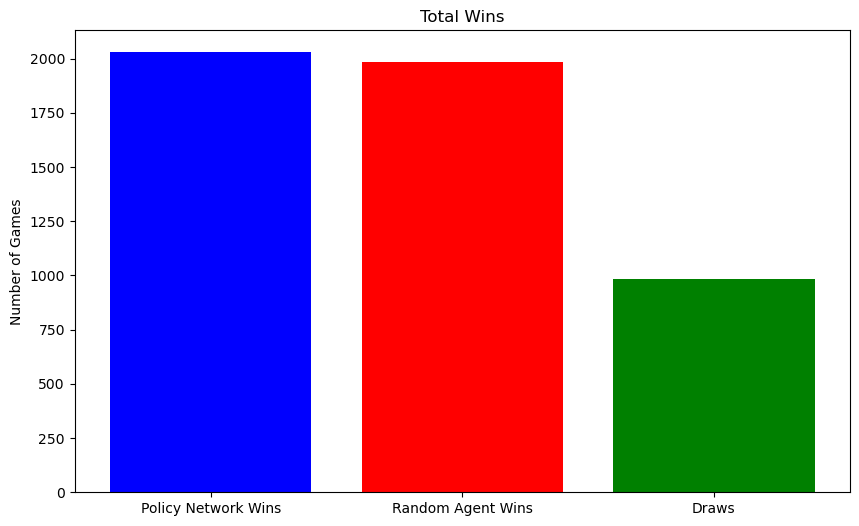

In [4]:
class RandomAgent:
    def __init__(self):
        pass

    def select_move(self, valid_moves_indices):
        """
        Selects a move randomly from the list of valid move indices.
        :param valid_moves_indices: A list of indices representing valid moves.
        :return: An index representing the selected move.
        """
        return random.choice(valid_moves_indices)

random_agent = RandomAgent()

def play_game_with_random(policy_model, game, random_start=True):
    if random_start:
        game.turn = random.choice([1, 2])
    
    while not game.is_game_over():
        if game.turn == 1:  # Policy network's turn
            state = convert_board_to_input(game.board)
            probs = policy_model(state)
            
            valid_moves = game.get_valid_moves_indices()
            action = select_move(probs, valid_moves)

            game.make_move_from_index(action)
            # print(1)
            # print(action)
            # print(np.unravel_index(action, (3, 3)))
        else:  # Random agent's turn
            valid_moves = game.get_valid_moves_indices()
            action = np.random.choice(valid_moves)
            game.make_move_from_index(action)
            # print(2)
            # print(action)
            # print(np.unravel_index(action, (3, 3)))
        # print(game)
        # print("------")
    return game.winner

wins = {1: 0, 2: 0, 0: 0}  # 1: Policy Network, 2: Random Agent, 0: Draw
num_simulations = 5000

for _ in range(num_simulations):
    winner = play_game_with_random(model, game, random_agent)
    wins[winner] += 1
    game.reset()  # Reset the game to its initial state after each simulation


# Plotting win rates
labels = ['Policy Network Wins', 'Random Agent Wins', 'Draws']
values = [wins[1], wins[2], wins[0]]

plt.figure(figsize=(10, 6))
plt.bar(labels, values, color=['blue', 'red', 'green'])
plt.title('Total Wins')
plt.ylabel('Number of Games')
plt.show()


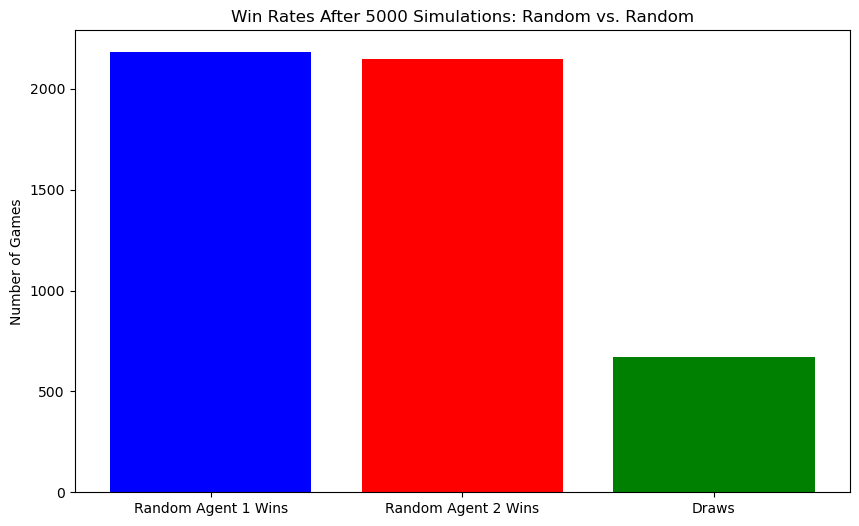

In [5]:
# Defining a function to simulate a game between two random agents
def play_game_random_vs_random(game, agent1, agent2):
    game.reset()
    # Randomly choose which agent starts
    game.turn = random.choice([1, 2])
    while not game.is_game_over():
        if game.turn == 1:  # Random agent 1's turn
            valid_moves_indices = game.get_valid_moves_indices()
            selected_move_index = agent1.select_move(valid_moves_indices)
            game.make_move_from_index(selected_move_index)
        else:  # Random agent 2's turn
            valid_moves_indices = game.get_valid_moves_indices()
            selected_move_index = agent2.select_move(valid_moves_indices)
            game.make_move_from_index(selected_move_index)
    return game.winner



# Initializing the game and two random agents
game = TicTacToe()
random_agent1 = RandomAgent()
random_agent2 = RandomAgent()

gameHistory = []

# Simulating games
wins_random_vs_random = {1: 0, 2: 0, 0: 0}  # 1: Random Agent 1, 2: Random Agent 2, 0: Draw
num_simulations_random_vs_random = 5000

for _ in range(num_simulations_random_vs_random):
    winner = play_game_random_vs_random(game, random_agent1, random_agent2)
    wins_random_vs_random[winner] += 1
    # Store a copy of the board's state and the winner at this point
    final_state = (np.copy(game.board), game.winner)
    gameHistory.append(final_state)
    game.reset()  # Reset the game to its initial state after each simulation

# Plotting win rates for games between two random agents
labels_random_vs_random = ['Random Agent 1 Wins', 'Random Agent 2 Wins', 'Draws']
values_random_vs_random = [wins_random_vs_random[1], wins_random_vs_random[2], wins_random_vs_random[0]]

plt.figure(figsize=(10, 6))
plt.bar(labels_random_vs_random, values_random_vs_random, color=['blue', 'red', 'green'])
plt.title('Win Rates After 5000 Simulations: Random vs. Random')
plt.ylabel('Number of Games')
plt.show()



In [7]:
state = convert_board_to_input(game.board)

In [8]:
state

tensor([[[[0., 0., 0.],
          [0., 0., 0.],
          [0., 0., 0.]]]])

In [9]:
print(game)

[[0 0 0]
 [0 0 0]
 [0 0 0]]


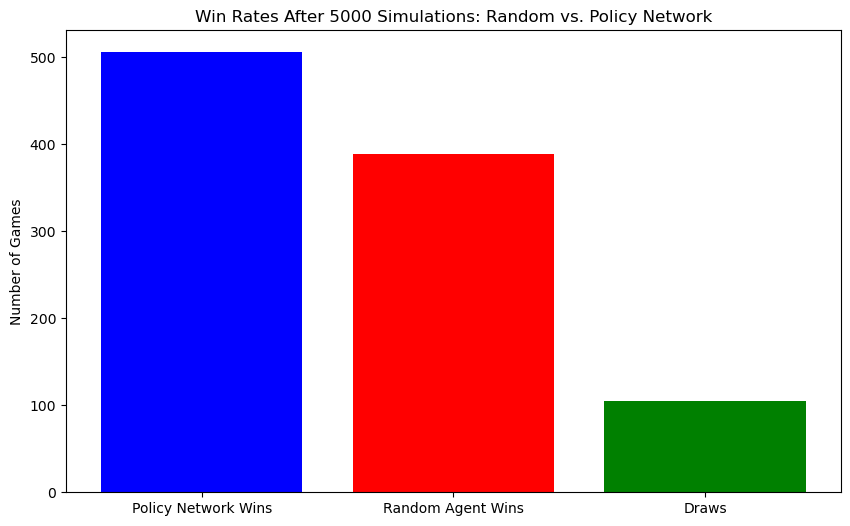

In [8]:
# test play_game_with_random
game = TicTacToe()
play_game_with_random(model, game)
random_agent = RandomAgent()
model = SimplePolicyNetwork(board_size, num_moves)


# Simulating games
wins_random_vs_policy = {1: 0, 2: 0, 0: 0}  # 1: Policy Network, 2: Random Agent, 0: Draw
num_simulations_random_vs_policy = 1000

for _ in range(num_simulations_random_vs_policy):
    game = TicTacToe()


    winner = play_game_with_random(model, game)
    wins_random_vs_policy[winner] += 1
    # assert False
    game.reset()  # Reset the game to its initial state after each simulation

# Plotting win rates for games between the policy network and a random agent
labels_random_vs_policy = ['Policy Network Wins', 'Random Agent Wins', 'Draws']
values_random_vs_policy = [wins_random_vs_policy[1], wins_random_vs_policy[2], wins_random_vs_policy[0]]

plt.figure(figsize=(10, 6))
plt.bar(labels_random_vs_policy, values_random_vs_policy, color=['blue', 'red', 'green'])
plt.title('Win Rates After 5000 Simulations: Random vs. Policy Network')
plt.ylabel('Number of Games')
plt.show()


In [9]:
def random_agent_benchmark(model, total_games=500, random_start=True):
    random_agent = RandomAgent()
    testGame = TicTacToe()
    win_count = 0
    loss_count = 0
    draw_count = 0
    for _ in range(total_games):
        testGame.reset()

        outcome = play_game_with_random(model, testGame, random_start=random_start)
        if outcome == 1:
            win_count += 1
        elif outcome == 2:
            loss_count += 1
        elif outcome == 0:
            draw_count += 1

    print(f"Win Rate: {win_count/total_games*100}%")
    print(f"Loss Rate: {loss_count/total_games*100}%")
    print(f"Draw Rate: {draw_count/total_games*100}%")


def compute_returns(rewards, gamma=1.0):
    """
    Compute returns for each time step, given the rewards
    and a discount factor gamma.
    """
    R = 0
    returns = []
    for r in reversed(rewards):
        R = r + gamma * R
        returns.insert(0, R)
    return returns

# Initialize environment, policy network, and optimizer
game = TicTacToe()
policy_network = SimplePolicyNetwork(board_size=(3, 3), num_moves=9)
optimizer = optim.Adam(policy_network.parameters(), lr=0.000001)

num_episodes = 10000





win_record = []
policy_losses = []  # Store policy losses for plotting
episode_rewards = []  # Average reward per episode

# Training loop
for episode in tqdm(range(num_episodes), desc="Processing Episodes"):
    saved_log_probs = []
    rewards = []
    game.reset()
    # game.turn = random.choice([1, 2])
    # print("Game: ", game)
    # print("Episode: ", episode)
    while not game.is_game_over():
        if game.turn == 1:  # Policy network's turn
            state = convert_board_to_input(game.board)
            probs = policy_network(state)
            # action = torch.multinomial(probs, 1).item()  # Sample action
            valid_moves = game.get_valid_moves_indices()
            action = select_move(probs, valid_moves)
            saved_log_probs.append(torch.log(probs.squeeze(0)[action]))
            game.make_move_from_index(action)
        else:  # Random agent's turn
            valid_moves = game.get_valid_moves_indices()
            action = np.random.choice(valid_moves)
            game.make_move_from_index(action)
        reward = get_reward(game)  # Define a suitable reward function
        rewards.append(reward)
    # print("reward: ", rewards)
    

    
    # Compute returns
    returns = compute_returns(rewards)
    returns = torch.tensor(returns)

    # Determine the outcome of the episode
    win_record.append(game.winner)
    episode_rewards.append(np.mean(rewards))
    
    # Collect individual loss tensors in a list
    policy_loss_terms = []
    for log_prob, R in zip(saved_log_probs, returns):
        loss = -log_prob * R
        policy_loss_terms.append(loss.unsqueeze(0))

    # Concatenate and sum to compute the total policy loss for the episode
    total_policy_loss = torch.cat(policy_loss_terms).sum()
    policy_losses.append(total_policy_loss.item())  # Recording scalar loss

    # Use total_policy_loss for gradient computation
    optimizer.zero_grad()
    total_policy_loss.backward()
    optimizer.step()

    interval = num_episodes // 10
    if episode > 0 and (episode) % interval == 0:
        random_agent_benchmark(policy_network, random_start=False)

# policy_network.save(model.state_dict(), "model_checkpoint.pth")



Processing Episodes:   0%|          | 0/10000 [00:00<?, ?it/s]

Win Rate: 70.19999999999999%
Loss Rate: 23.599999999999998%
Draw Rate: 6.2%
Win Rate: 75.8%
Loss Rate: 13.200000000000001%
Draw Rate: 11.0%
Win Rate: 83.2%
Loss Rate: 8.6%
Draw Rate: 8.200000000000001%
Win Rate: 86.2%
Loss Rate: 9.4%
Draw Rate: 4.3999999999999995%
Win Rate: 84.8%
Loss Rate: 10.2%
Draw Rate: 5.0%
Win Rate: 85.39999999999999%
Loss Rate: 10.2%
Draw Rate: 4.3999999999999995%
Win Rate: 89.8%
Loss Rate: 7.000000000000001%
Draw Rate: 3.2%
Win Rate: 84.8%
Loss Rate: 10.0%
Draw Rate: 5.2%
Win Rate: 89.0%
Loss Rate: 6.800000000000001%
Draw Rate: 4.2%


AttributeError: 'SimplePolicyNetwork' object has no attribute 'save'

In [11]:
print("Number of policy network moves:", len(saved_log_probs))


Number of policy network moves: 2


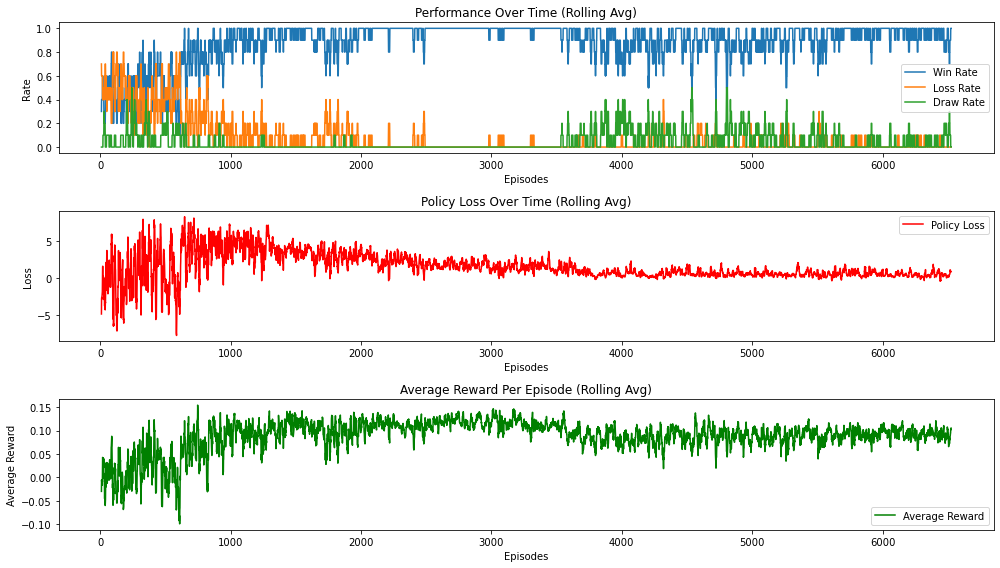

In [86]:
# Plotting results of training against a random agent

# Function to calculate rolling average using np.convolve
def calculate_rolling_average(data, window_size=10):
    window = np.ones(window_size) / window_size
    return np.convolve(data, window, 'valid')

# Convert win_record to binary for win, loss, and draw
wins_binary = (np.array(win_record) == 1).astype(float)
losses_binary = (np.array(win_record) == 2).astype(float)
draws_binary = (np.array(win_record) == 0).astype(float)

# Calculate rolling averages
rolling_avg_win_rate = calculate_rolling_average(wins_binary)
rolling_avg_loss_rate = calculate_rolling_average(losses_binary)
rolling_avg_draw_rate = calculate_rolling_average(draws_binary)
rolling_avg_policy_losses = calculate_rolling_average(policy_losses)
rolling_avg_episode_rewards = calculate_rolling_average(episode_rewards)

# Plotting
window_size = 10  # Adjust window_size if needed

plt.figure(figsize=(14, 8))

# Win, Loss, Draw Rates
plt.subplot(3, 1, 1)
episodes_adjusted = np.arange(window_size, len(win_record) + 1)
plt.plot(episodes_adjusted, rolling_avg_win_rate, label='Win Rate')
plt.plot(episodes_adjusted, rolling_avg_loss_rate, label='Loss Rate')
plt.plot(episodes_adjusted, rolling_avg_draw_rate, label='Draw Rate')
plt.xlabel('Episodes')
plt.ylabel('Rate')
plt.title('Performance Over Time (Rolling Avg)')
plt.legend()

# Policy Loss
plt.subplot(3, 1, 2)
plt.plot(episodes_adjusted, rolling_avg_policy_losses, label='Policy Loss', color='red')
plt.xlabel('Episodes')
plt.ylabel('Loss')
plt.title('Policy Loss Over Time (Rolling Avg)')
plt.legend()

# Average Rewards
plt.subplot(3, 1, 3)
plt.plot(episodes_adjusted, rolling_avg_episode_rewards, label='Average Reward', color='green')
plt.xlabel('Episodes')
plt.ylabel('Average Reward')
plt.title('Average Reward Per Episode (Rolling Avg)')
plt.legend()

plt.tight_layout()
plt.show()


In [87]:


game = TicTacToe()
policy_network = SimplePolicyNetwork(board_size=(3, 3), num_moves=9)
optimizer = optim.Adam(policy_network.parameters(), lr=0.000001)

random_agent_benchmark(policy_network)

def self_play(episodes):
    win_record = []  # To track win/lose/draw
    policy_losses = []  # To track policy losses for plotting
    episode_rewards = []  # To track rewards for each episode
    
    for episode in tqdm(range(episodes), desc="Self-Play Episodes"):
        game.reset()
        saved_log_probs = []
        rewards = []
        
        while not game.is_game_over():
            state = convert_board_to_input(game.board)
            probs = policy_network(state)
            # action = torch.multinomial(probs, 1).item()
            action = select_move(probs, game.get_valid_moves_indices())
            saved_log_probs.append(torch.log(probs.squeeze(0)[action]))
            game.make_move_from_index(action)
            # reward = get_reward(game)  # Assuming existence of a suitable reward function
            # rewards.append(reward)
        
        # Determine the outcome of the episode
        win_record.append(game.winner)  # Assuming game.winner is set appropriately
        if game.winner == 0:
            returns = [0] * len(saved_log_probs)
        elif game.winner == 2:
            returns = [-1 if i % 2 == 0 else 1 for i in range(len(saved_log_probs))]
        else:
            returns = [1 if i % 2 == 0 else -1 for i in range(len(saved_log_probs))]
        # for i in range(len(win_record)):
        #     if win_record[i] == 1:
        #         c = 1
        #     elif win_record[i] == 2:
        #         c = -1
        #     else:
        #         c = 0
        #     # multiply the reward by the outcome of the game
        #     rewards[i] = [c * rewards[i][j] for j in range(len(rewards[i]))]

        # Compute returns and update the policy
        # returns = compute_returns(rewards, gamma=1.0)  # Assuming gamma=1.0 for simplicity
        returns = torch.tensor(returns, dtype=torch.float32)

        

        
        policy_loss_terms = [-log_prob * R for log_prob, R in zip(saved_log_probs, returns)]
        # Ensure each term is unsqueezed to have 1 dimension for concatenation
        policy_loss_terms = [loss_term.unsqueeze(0) for loss_term in policy_loss_terms]
        total_policy_loss = torch.cat(policy_loss_terms).sum()

        policy_losses.append(total_policy_loss.item())  # Recording scalar loss
        
        # Track average rewards for this episode
        episode_rewards.append(np.mean(rewards))
        
        optimizer.zero_grad()
        total_policy_loss.backward()
        optimizer.step()

        interval = episodes // 10
        if episode > 0 and (episode) % interval == 0:
            random_agent_benchmark(policy_network)


    # After all episodes, calculate and print summary statistics
    print(f"Average policy loss: {np.mean(policy_losses)}")
    print(f"Average reward per episode: {np.mean(episode_rewards)}")
    # Assuming 1 represents wins for the policy network, 2 for opponent, and 0 for draw
    
    interval = num_episodes // 10
    if episode > 0 and (episode) % interval == 0:
        random_agent_benchmark(policy_network)

# Example call to the self_play function
self_play(episodes=1000)

Win Rate: 42.4%


Self-Play Episodes:   0%|          | 0/1000 [00:00<?, ?it/s]

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


Win Rate: 47.0%
Win Rate: 45.6%
Win Rate: 47.4%
Win Rate: 42.6%
Win Rate: 51.2%
Win Rate: 50.0%
Win Rate: 45.0%
Win Rate: 49.8%
Win Rate: 44.0%
Average policy loss: 0.1954676878452301
Average reward per episode: nan


In [ ]:
# play